In [94]:
import os
from pathlib import Path
import numpy as np

In [95]:
cwd = Path(os.getcwd())
PROJETC_ROOT = cwd.parent
DATA_PATH = PROJETC_ROOT / "data"

# basis = np.load(DATA_PATH / "basis.npz")["matrix"]

In [96]:
# RESULTS_DIR = PROJECT_ROOT / "results" / "pca" / "non-normalized"

## Dataset size

In [97]:
# num_samples = basis.shape[0]
# original_num_features = basis.shape[1]

# print(f"Number of samples: {num_samples}")
# print(f"Number of features: {original_num_features}")

In [98]:
# X_NORM = np.load(DATA_PATH / 'X_norm.npz')['X_norm']
# X = np.load(DATA_PATH / 'X.npz')['X']

## Experiments options

### Gathering results

In [99]:
RESULTS_DIR = PROJETC_ROOT/ "results"

In [100]:
methods = ["PCA", "PaCMAP", "tSNE", "TriMAP", "UMAP"]
methods =[m.lower() for m in methods]

archs = ["CPU", "GPU"]
archs = [a.lower() for a in archs]

dataset_options = ["normalized", "non_normalized", "non-normalized"]

In [101]:
from dataclasses import dataclass
import re
from typing import Optional


@dataclass
class LogMetrics:
    timestamp: Optional[str] = None
    method_details: Optional[str] = None
    explained_variance_first_2: Optional[tuple[float, float]] = None
    total_explained_variance_100_comps: Optional[float] = None
    components_for_90_variance: Optional[int] = None
    wall_time_s: Optional[float] = None
    cpu_time_user_s: Optional[float] = None
    cpu_time_sys_s: Optional[float] = None
    cpu_time_total_s: Optional[float] = None
    gpu_kernel_time_s: Optional[float] = None
    gpu_memory_used_mb: Optional[float] = None
    gpu_memory_total_mb: Optional[float] = None
    gpu_model: Optional[str] = None
    gpu_driver: Optional[str] = None
    points: Optional[int] = None
    original_dims: Optional[int] = None
    pca_dims_saved: Optional[int] = None
    hostname: Optional[str] = None
    # Add other fields if necessary for other log types

def parse_log_metrics(log_content: str) -> LogMetrics:
    data = LogMetrics()
    for line in log_content.splitlines():
        line = line.strip()
        if not line:
            continue

        if data.timestamp is None and line.startswith("["):
            match_header = re.match(r"\[(.*?)\]\s*(.*)", line)
            if match_header:
                data.timestamp = match_header.group(1)
                data.method_details = match_header.group(2)
                continue
        
        m = re.search(r"Wall time: ([\d.]+) s", line)
        if m: data.wall_time_s = float(m.group(1)); continue
        
        m = re.search(r"CPU times: user ([\d.]+) s, sys ([\d.]+) s, total ([\d.]+) s", line)
        if m:
            data.cpu_time_user_s = float(m.group(1))
            data.cpu_time_sys_s = float(m.group(2))
            data.cpu_time_total_s = float(m.group(3))
            continue
        
        m = re.search(r"Explained variance \(first 2\): ([\d.]+)%, ([\d.]+)%", line)
        if m: data.explained_variance_first_2 = (float(m.group(1)), float(m.group(2))); continue
        
        m = re.search(r"Total explained variance \((\d+) comps\): ([\d.]+)%", line)
        if m: data.total_explained_variance_100_comps = float(m.group(2)); continue
            
        m = re.search(r"Components needed for >=90% variance: (\d+)", line)
        if m: data.components_for_90_variance = int(m.group(1)); continue

        m = re.search(r"GPU kernel time: ([\d.]+) s", line)
        if m: data.gpu_kernel_time_s = float(m.group(1)); continue

        m = re.search(r"GPU memory used: ([\d.]+) MB / ([\d.]+) MB", line)
        if m:
            data.gpu_memory_used_mb = float(m.group(1))
            data.gpu_memory_total_mb = float(m.group(2))
            continue

        m = re.search(r"GPU model: (.*?), Driver: (.*)", line)
        if m:
            data.gpu_model = m.group(1).strip()
            data.gpu_driver = m.group(2).strip()
            continue

        m = re.search(r"Points: (\d+), Original dims: (\d+), PCA dims saved: (\d+)", line)
        if m:
            data.points = int(m.group(1))
            data.original_dims = int(m.group(2))
            data.pca_dims_saved = int(m.group(3))
            continue
        
        m = re.search(r"Hostname: (.*)", line)
        if m: data.hostname = m.group(1).strip(); continue
    return data

In [102]:
from typing import List


@dataclass
class ExperimentResult:
    method: str
    architecture: str
    dataset_type: str
    metrics: LogMetrics
    precomputed_pca: str | None
    original_method_arch_string: str

all_experiment_results: List[ExperimentResult] = []


In [103]:
RESULTS_DIR

WindowsPath('c:/Users/basia/Desktop/Semestr_letni_8/LCS/projekt_2/LSC_Dimensionality_Reduction/results')

In [104]:
TEST_DIR_TO_SKIP = "test"

In [147]:
log_metrics_data = []
all_experiment_results = []

match = lambda parampacmap_substr: any(m.lower() in parampacmap_substr.lower() for m in methods) # Case of parampacmap

for time_file_path in RESULTS_DIR.rglob("*_time.txt"):
    if TEST_DIR_TO_SKIP in str(time_file_path):
        continue
    if time_file_path.is_file():
        # Store log metrics          
        log_content = time_file_path.read_text(encoding='utf-8')
        log_metrics = parse_log_metrics(log_content)
        log_metrics_data.append(log_metrics)

        # Parse path to extract method, architecture, dataset type, and precomputed PCA
        relative_to_project_root = time_file_path.relative_to(RESULTS_DIR)
        path = os.sep + str(relative_to_project_root)
        path = path[1:] # Remove first slash

        parts_with_os_sep = path.split(os.sep)

        method = None
        normalized = "non_normalized"
        arch = "cpu"
        precomputed_pca = None

        for part in parts_with_os_sep:
            part = part.lower() # just to make sure

            if "_" in part:
                original_part = part
                parts = part.split("_") # Output: ['pacmap', 'cpu']
                for subpart in parts:
                    if "cmlu" in subpart:
                        arch = "gpu"
                    if subpart in methods or match(subpart):
                        method = subpart
                    elif subpart in dataset_options:
                        if subpart == "raw":
                            normalized = "non_normalized"
                        normalized = subpart
                    elif subpart in archs:
                        arch = subpart
                    elif "pca" in subpart:
                        precomputed_pca = True

            if "cmlu" in part:
                arch = "gpu"
            if part in methods:
                method = part
            elif part in dataset_options:
                if part == "raw" or part == "non-normalized":
                    part = "non_normalized"
                normalized = part
            elif part in archs:
                arch = part
            elif "pca" in part:
                precomputed_pca = True

        experiment = ExperimentResult(
                method=method,
                architecture=arch,
                dataset_type=normalized,
                metrics=log_metrics,
                precomputed_pca=precomputed_pca,
                original_method_arch_string=original_part
            )
        all_experiment_results.append(experiment)

In [106]:
import pandas as pd

In [107]:
import pandas as pd

In [108]:
df_metrics = pd.DataFrame([vars(metric) for metric in log_metrics_data])

In [109]:
df_results = pd.DataFrame([vars(res) for res in all_experiment_results])

In [110]:
if all_experiment_results:
    experiment_data_for_df = []
    for exp in all_experiment_results:
        exp_vars = vars(exp).copy()
        # print(exp_vars)

        if 'metrics' in exp_vars:
            metrics_data = exp_vars.pop('metrics')
            metrics_vars = metrics_data.__dict__
            combined_vars = {**exp_vars, **metrics_vars}
        else:
            combined_vars = exp_vars
        experiment_data_for_df.append(combined_vars)
    
    df_experiments = pd.DataFrame(experiment_data_for_df)


else:
    print("'all_experiment_results' is empty.")

df_experiments['wall_time_s'] = pd.to_numeric(df_experiments['wall_time_s'], errors='coerce')

In [111]:
df_experiments["wall_time_s"]

0      1720.77
1      1941.74
2      1867.88
3      1746.97
4      1826.25
5      2294.74
6      2391.95
7      2166.80
8      2186.67
9        11.13
10       12.68
11       11.71
12        1.23
13        0.87
14     2771.53
15     3061.69
16     3648.95
17     2941.83
18     2731.92
19     1569.49
20     1597.14
21      816.92
22      893.91
23      338.95
24      326.99
25       71.42
26    18561.19
27     2298.71
28     1893.86
29     1868.19
30     1464.29
31     1602.06
32       30.72
33       29.40
34       25.60
35       24.27
36       24.37
37       26.96
Name: wall_time_s, dtype: float64

In [112]:
# ...existing code...
# Ensure df_experiments is created and populated correctly first.
# For example, from cell '4ab83867'

if 'df_experiments' in locals() and not df_experiments.empty:
    if 'dataset_type' in df_experiments.columns and 'wall_time_s' in df_experiments.columns:
        
        # Ensure wall_time_s is numeric, coercing errors to NaN
        df_experiments['wall_time_s'] = pd.to_numeric(df_experiments['wall_time_s'], errors='coerce')
        
        # Drop rows where wall_time_s might have become NaN after coercion, or if dataset_type is NaN
        df_cleaned_for_grouping = df_experiments.dropna(subset=['wall_time_s', 'dataset_type'])

        if not df_cleaned_for_grouping.empty:
            # Find the index of the row with the minimum wall_time_s for each dataset_type
            # idxmin() returns the index of the first occurrence of the minimum value in each group.
            idx_min_wall_time_per_group = df_cleaned_for_grouping.groupby('dataset_type')['wall_time_s'].idxmin()

            # Use these indices to select the complete rows for the best experiments in each group
            df_best_experiments_by_dataset_type = df_cleaned_for_grouping.loc[idx_min_wall_time_per_group]

            # Sort the resulting DataFrame by wall_time_s to see the overall fastest among the group bests
            df_best_experiments_by_dataset_type_sorted = df_best_experiments_by_dataset_type.sort_values(by='wall_time_s')

            print("Best experiments (minimum wall_time_s) per dataset_type:")
            # Display relevant columns
            columns_to_show = ['dataset_type', 'method', 'architecture', 'wall_time_s', 'original_method_arch_string', 'precomputed_pca']
            existing_columns_to_show = [col for col in columns_to_show if col in df_best_experiments_by_dataset_type_sorted.columns]
            print(df_best_experiments_by_dataset_type_sorted[existing_columns_to_show])
        else:
            print("DataFrame is empty after cleaning NaNs from 'wall_time_s' or 'dataset_type'. Cannot group.")
    else:
        print("Error: 'dataset_type' or 'wall_time_s' column not found in df_experiments.")
else:
    print("Error: df_experiments is not defined or is empty.")

Best experiments (minimum wall_time_s) per dataset_type:
      dataset_type method architecture  wall_time_s  \
13      normalized    pca          gpu         0.87   
12  non_normalized    pca          gpu         1.23   

   original_method_arch_string precomputed_pca  
13                pca_time.txt            True  
12                pca_time.txt            True  


In [113]:
df_experiments.groupby('dataset_type')["method"].describe()

,count,unique,top,freq
dataset_type,,,,
non_normalized,17,5,umap,7
normalized,19,5,tsne,5


In [114]:
df_experiments.groupby('dataset_type')[['wall_time_s', "method"]].describe()

wall_time_s                                                     \
                     count         mean          std   min       25%      50%   
dataset_type                                                                    
non_normalized        18.0  1091.632222  1127.372861  1.23   25.0175   954.22   
normalized            20.0  2357.618500  3957.918299  0.87  694.4375  1786.61   

                                   
                    75%       max  
dataset_type                       
non_normalized  1929.77   3061.69  
normalized      2237.99  18561.19

In [115]:
grouped = df_experiments.groupby(['method', 'architecture', 'dataset_type', "wall_time_s"])
grouped.size()

method  architecture  dataset_type    wall_time_s
pacmap  cpu           non_normalized  1720.77        1
                                      1941.74        1
                      normalized      1746.97        1
                                      1826.25        1
                                      1867.88        1
pca     cpu           non_normalized  11.13          1
                                      12.68          1
                      normalized      11.71          1
        gpu           non_normalized  1.23           1
                      normalized      0.87           1
                                      2166.80        1
                                      2186.67        1
trimap  cpu           non_normalized  2771.53        1
                                      3061.69        1
                      normalized      2731.92        1
                                      2941.83        1
                                      3648.95        1
tsne    cpu    

In [116]:
df_experiments_sorted_by_wall_time_asc = df_experiments.sort_values(by='wall_time_s', ascending=True)

In [117]:
df_experiments_sorted_by_wall_time_asc.groupby(['method', 'architecture', 'dataset_type'])['wall_time_s'].min().reset_index()

,method,architecture,dataset_type,wall_time_s
0,pacmap,cpu,non_normalized,1720.77
1,pacmap,cpu,normalized,1746.97
2,pca,cpu,non_normalized,11.13
3,pca,cpu,normalized,11.71
4,pca,gpu,non_normalized,1.23
5,pca,gpu,normalized,0.87
6,trimap,cpu,non_normalized,2771.53
7,trimap,cpu,normalized,2731.92
8,tsne,cpu,non_normalized,1569.49
9,tsne,cpu,normalized,816.92


In [118]:
df_experiments_sorted_by_wall_time_asc.groupby(['method', 'architecture', 'dataset_type'])['wall_time_s'].min().reset_index()

,method,architecture,dataset_type,wall_time_s
0,pacmap,cpu,non_normalized,1720.77
1,pacmap,cpu,normalized,1746.97
2,pca,cpu,non_normalized,11.13
3,pca,cpu,normalized,11.71
4,pca,gpu,non_normalized,1.23
5,pca,gpu,normalized,0.87
6,trimap,cpu,non_normalized,2771.53
7,trimap,cpu,normalized,2731.92
8,tsne,cpu,non_normalized,1569.49
9,tsne,cpu,normalized,816.92


In [119]:
df_experiments_sorted_by_wall_time_asc[['wall_time_s', 'method', 'architecture', 'dataset_type']]

,wall_time_s,method,architecture,dataset_type
13,0.87,pca,gpu,normalized
12,1.23,pca,gpu,non_normalized
9,11.13,pca,cpu,non_normalized
11,11.71,pca,cpu,normalized
10,12.68,pca,cpu,non_normalized
35,24.27,umap,gpu,non_normalized
36,24.37,umap,gpu,non_normalized
34,25.60,umap,gpu,normalized
37,26.96,umap,gpu,non_normalized
33,29.40,umap,gpu,non_normalized


In [120]:
cols_to_display = ["wall_time_s"]
df_experiments.groupby(['method', 'architecture', 'dataset_type'])[cols_to_display]

In [121]:
normalized = df_experiments[df_experiments['dataset_type'] == 'normalized']

In [127]:
grouped = normalized.groupby(['method', 'architecture']).agg({'wall_time_s': ["min", "mean", 'count']})
grouped.sort_values(by=('wall_time_s', 'min'), ascending=True)

wall_time_s                   
                            min         mean count
method architecture                               
pca    gpu                 0.87  1451.446667     3
       cpu                11.71    11.710000     1
umap   gpu                25.60    25.600000     1
tsne   gpu                71.42  6319.866667     3
       cpu               816.92   855.415000     2
umap   cpu              1464.29  1644.846667     3
pacmap cpu              1746.97  1813.700000     3
trimap cpu              2731.92  3107.566667     3

In [123]:
gr = df_experiments.groupby(['method', 'architecture', 'dataset_type']).agg({"wall_time_s": "mean"})
gr

wall_time_s
method architecture dataset_type               
pacmap cpu          non_normalized  1831.255000
                    normalized      1813.700000
pca    cpu          non_normalized    11.905000
                    normalized        11.710000
       gpu          non_normalized     1.230000
                    normalized      1451.446667
trimap cpu          non_normalized  2916.610000
                    normalized      3107.566667
tsne   cpu          non_normalized  1583.315000
                    normalized       855.415000
       gpu          non_normalized   338.950000
                    normalized      6319.866667
umap   cpu          non_normalized  2096.285000
                    normalized      1644.846667
       gpu          non_normalized    27.144000
                    normalized        25.600000

<Axes: ylabel='method,architecture,dataset_type'>

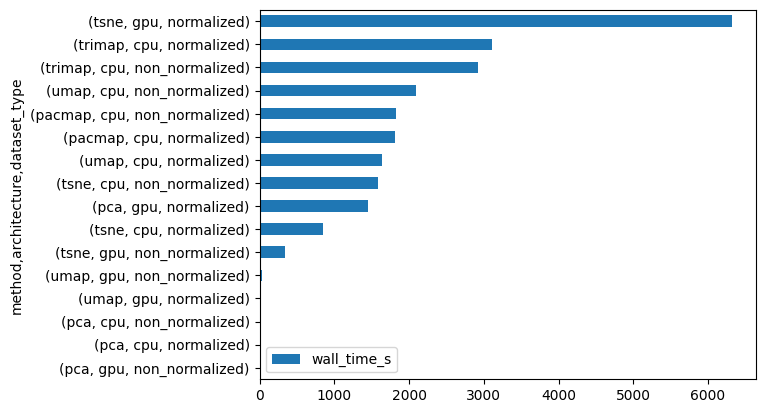

In [124]:
res = gr.apply(lambda x: x.sort_values(ascending=True))
res.plot(kind="barh")

In [125]:
res_non_normalized = res.query("dataset_type == 'non_normalized'")
res_non_normalized


wall_time_s
method architecture dataset_type               
pca    gpu          non_normalized        1.230
       cpu          non_normalized       11.905
umap   gpu          non_normalized       27.144
tsne   gpu          non_normalized      338.950
       cpu          non_normalized     1583.315
pacmap cpu          non_normalized     1831.255
umap   cpu          non_normalized     2096.285
trimap cpu          non_normalized     2916.610

In [ ]:
gr = df_experiments.groupby(['method', 'architecture', 'dataset_type']).agg({"wall_time_s": "mean"}).reset_index()
gr

In [ ]:
gr

In [ ]:
import re

log_content = """
[2025-06-06T18:44:14.128470] PCA (AFDB, cuML GPU)
Explained variance (first 2): 51.92%, 18.80%
Total explained variance (100 comps): 98.43%
Components needed for >=90% variance: 10
Wall time: 1.23 s
CPU times: user 0.60 s, sys 0.09 s, total 0.69 s
GPU kernel time: 1.042 s
GPU memory used: 654.3 MB / 42600.3 MB
GPU model: NVIDIA A100-SXM4-40GB, Driver: 570.133.20
Points: 1505141, Original dims: 844, PCA dims saved: 10
Hostname: t0025
"""

wall_time = None
cpu_user_time = None
cpu_sys_time = None
cpu_total_time = None

for line in log_content.splitlines():
    if line.startswith("Wall time:"):
        match = re.search(r"Wall time: ([\d.]+) s", line)
        if match:
            wall_time = float(match.group(1))
    elif line.startswith("CPU times:"):
        match = re.search(r"user ([\d.]+) s, sys ([\d.]+) s, total ([\d.]+) s", line)
        if match:
            cpu_user_time = float(match.group(1))
            cpu_sys_time = float(match.group(2))
            cpu_total_time = float(match.group(3))

print(f"Wall time: {wall_time} s")
print(f"CPU user time: {cpu_user_time} s")
print(f"CPU sys time: {cpu_sys_time} s")
print(f"CPU total time: {cpu_total_time} s")